# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


## ⚙️ Import Libraries

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


## ⏳ Load the Data

In [ ]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


## 🔎 Inspect Data

In [ ]:
# Indices to remove
indices = [
    62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339,
    348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 799, 802, 808, 820,
    821, 849, 863, 890, 909, 942, 971, 1005, 1047, 1057, 1079, 1082, 1092, 1095, 1106,
    1119, 1125, 1177, 1194, 1124, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370,
    1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768,
    1782, 1804, 1813, 1816, 1834, 1839, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086,
    2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365,
    2372, 2414, 2453, 2552, 2535, 2561, 2609, 2614
]

# Remove the specified indices
X_train = np.delete(X_train, indices, axis=0)
y_train = np.delete(y_train, indices, axis=0)

# Confirm the shapes after removal
print(f"Training images shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")

Training images shape: (2504, 64, 128)
Training labels shape: (2504, 64, 128)



Pixel counts per class:
Class 0 (Background): 4974755 pixels
Class 1 (Soil): 6958113 pixels
Class 2 (Bedrock): 4778177 pixels
Class 3 (Sand): 3774760 pixels
Class 4 (Big Rock): 26963 pixels


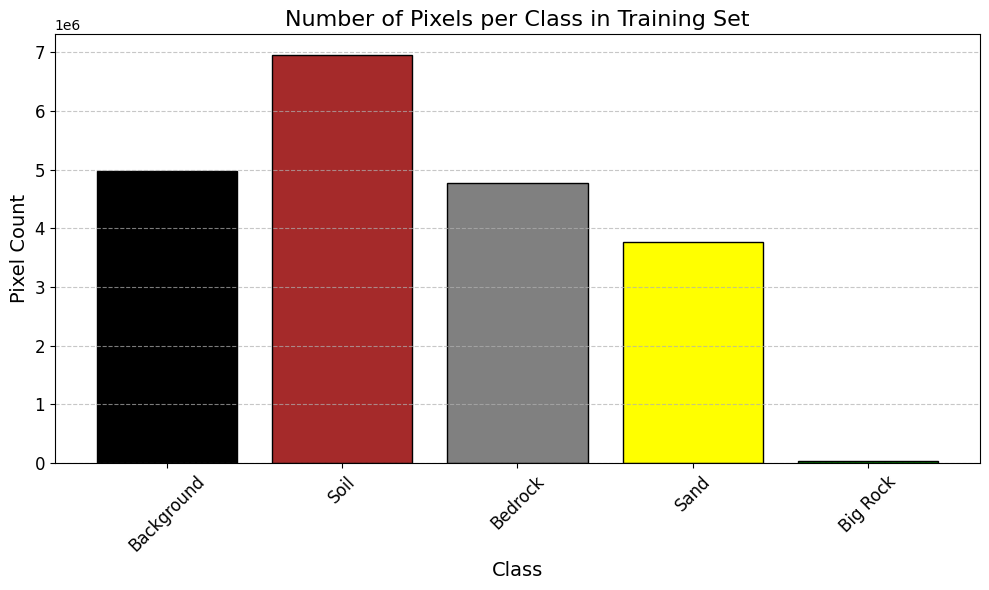

In [ ]:
from collections import Counter # Import the Counter class from the collections module

# Define class names and colors
class_names = {
    0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
}
class_colors = ["black", "brown", "gray", "yellow", "green"]  # One color per class

# Flatten y_train to count pixel occurrences across all masks
y_train_flat = y_train.flatten()

# Count pixel occurrences per class
class_counts = Counter(y_train_flat)

# Ensure all classes are represented in the counts (even if they are 0)
classes = list(class_names.keys())
counts = [class_counts[class_id] for class_id in classes]

# Print pixel counts per class
print("\nPixel counts per class:")
for class_id, count in zip(classes, counts):
    print(f"Class {class_id} ({class_names[class_id]}): {count} pixels")

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color=class_colors, edgecolor='black')
plt.title('Number of Pixels per Class in Training Set', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Pixel Count', fontsize=14)
plt.xticks(classes, [class_names[c] for c in classes], fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 🔄 Process Data

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

Train set: (2003, 64, 128, 1), (2003, 64, 128)
Validation set: (501, 64, 128, 1), (501, 64, 128)


## 🛠️ Train and Save the Model

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=42):
    tf.random.set_seed(seed)
    input_layer = tf.keras.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tf.keras.layers.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tf.keras.layers.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tf.keras.layers.UpSampling2D()(bottleneck)
    u1 = tf.keras.layers.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tf.keras.layers.UpSampling2D()(u1)
    u2 = tf.keras.layers.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tf.keras.layers.Conv2D(num_classes, kernel_size=1, padding='same',
                                          activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

## Viz_callback

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, class_names):
        super().__init__()
        self.image = np.copy(image)  # Copy of the example image
        self.label = np.copy(label)  # Copy of the corresponding mask
        self.class_names = class_names  # List of class names

    def on_epoch_end(self, epoch, logs=None):
        # Visualize every 10 epochs
        if (epoch + 1) % 10 == 0:  # Check if the epoch is a multiple of 10
            # Prediction
            pred = self.model.predict(self.image, verbose=0)  # Inference
            y_pred = tf.math.argmax(pred, axis=-1)  # Argmax over num_classes, output: (1, height, width)
            y_pred = np.array(y_pred)  # Convert the result to a numpy array

            # Remove the batch dimension (1)
            y_pred = y_pred[0]  # Output with shape (height, width)
            label = self.label[0, :, :, 0]  # Output with shape (height, width)
            image = self.image[0, :, :, 0]  # Output the original image (assuming grayscale)

            # Define the color map (using 'jet' or 'viridis')
            cmap = plt.cm.viridis

            # Plot
            fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # Three columns
            axes[0].imshow(image, cmap='gray')  # Visualize the original image
            axes[0].set_title("Original Image")

            # Visualize the original mask
            axes[1].imshow(label, cmap=cmap)
            axes[1].set_title("Original Mask")

            # Visualize the predicted mask
            axes[2].imshow(y_pred, cmap=cmap)
            axes[2].set_title("Predicted Mask")

            # Create a legend showing the color classes
            handles = []
            for i, class_name in enumerate(self.class_names):
                color = cmap(i / (len(self.class_names) - 1))  # Normalize class index to cmap range
                handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=class_name))

            plt.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.2, 1), title='Classes')

            plt.tight_layout()
            plt.show()

# Select an image and its corresponding label from the dataset
example_image = X_train[2]  # Select the first image
example_label = y_train[2]  # Select the first label

# Prepare the image and label
image = np.expand_dims(example_image, axis=0)  # Add the batch dimension
image = np.expand_dims(image, axis=-1)         # Add the channel dimension

label = np.expand_dims(example_label, axis=0)  # Add the batch dimension
label = np.expand_dims(label, axis=-1)         # Add the channel dimension

# Define class names
class_names = ['background', 'soil', 'bedrock', 'sand', 'big rock']

# Initialize the callback with class names
viz_callback = VizCallback(image, label, class_names)


In [ ]:
# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

model = get_unet_model(input_shape=input_shape, num_classes=num_classes)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=[mean_iou])
callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_delta=1e-5),
        viz_callback
    ]
model.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_conv1         │ (None, 64, 128, 32)    │            320 │ input_layer[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_bn1           │ (None, 64, 128, 32)    │            128 │ down_block1_conv1[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_activation1   │ (None, 64, 128, 32)    │              0 │ down_block1_bn1[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_conv2         │ (None, 64, 128, 32)    │          9,248 │ down_block1_activatio… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_bn2           │ (None, 64, 128, 32)    │            128 │ down_block1_conv2[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_activation2   │ (None, 64, 128, 32)    │              0 │ down_block1_bn2[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 64, 32)     │              0 │ down_block1_activatio… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_conv1         │ (None, 32, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_bn1           │ (None, 32, 64, 64)     │            256 │ down_block2_conv1[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_activation1   │ (None, 32, 64, 64)     │              0 │ down_block2_bn1[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_conv2         │ (None, 32, 64, 64)     │         36,928 │ down_block2_activatio… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_bn2           │ (None, 32, 64, 64)     │            256 │ down_block2_conv2[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_activatio

 Total params: 473,669 (1.81 MB)

 Trainable params: 472,389 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

## 🧠 Train the model

Epoch 1/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 371ms/step - loss: 1.4146 - mean_io_u: 0.1900 - val_loss: 2.1883 - val_mean_io_u: 0.0667 - learning_rate: 0.0010
Epoch 2/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 1.1213 - mean_io_u: 0.2709 - val_loss: 5.3509 - val_mean_io_u: 0.0667 - learning_rate: 0.0010
Epoch 3/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 1.0334 - mean_io_u: 0.2998 - val_loss: 4.5666 - val_mean_io_u: 0.0667 - learning_rate: 0.0010
Epoch 4/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.9464 - mean_io_u: 0.3375 - val_loss: 5.2940 - val_mean_io_u: 0.0667 - learning_rate: 0.0010
Epoch 5/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.8984 - mean_io_u: 0.3595 - val_loss: 5.4369 - val_mean_io_u: 0.0534 - learning_rate: 0.0010
Epoch 6/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.8655 - mean_io_u: 0.3638 - val_loss: 4.6224 - val_mean_io_u: 0.0535 - learning_rate: 0.0010
Epoch 7/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.8540 - mean_

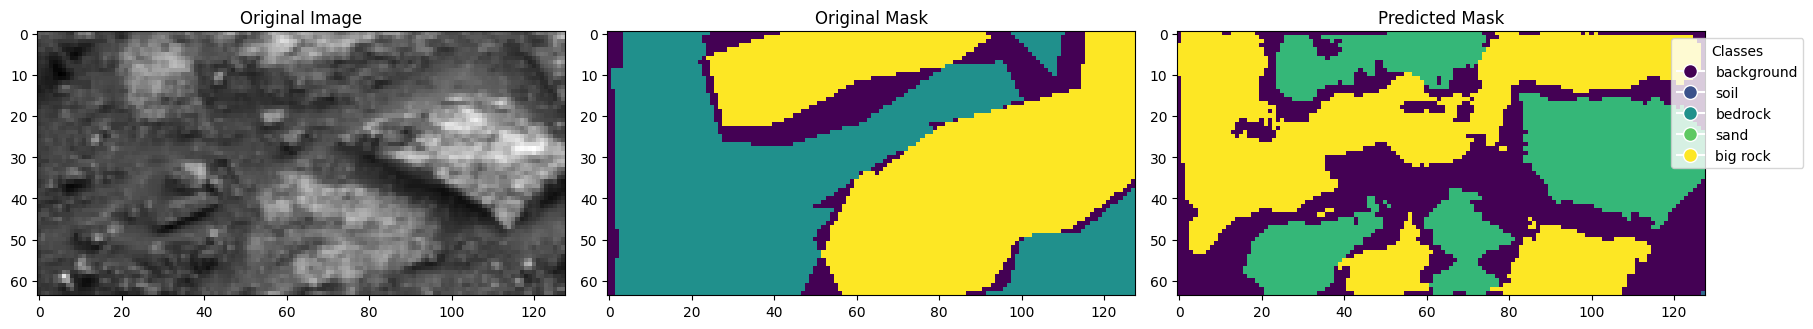

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.8003 - mean_io_u: 0.3958 - val_loss: 1.9264 - val_mean_io_u: 0.1613 - learning_rate: 0.0010
Epoch 11/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.7872 - mean_io_u: 0.4015 - val_loss: 1.0040 - val_mean_io_u: 0.3293 - learning_rate: 0.0010
Epoch 12/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.7559 - mean_io_u: 0.4153 - val_loss: 1.6578 - val_mean_io_u: 0.2115 - learning_rate: 0.0010
Epoch 13/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.7512 - mean_io_u: 0.4171 - val_loss: 1.5302 - val_mean_io_u: 0.0805 - learning_rate: 0.0010
Epoch 14/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.7347 - mean_io_u: 0.4240 - val_loss: 1.4560 - val_mean_io_u: 0.1630 - learning_rate: 0.0010
Epoch 15/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.7301 - mean_io_u: 0.4236 - val_loss: 1.1021 - val_mean_io_u: 0.2387 - learning_rate: 0.0010
Epoch 16/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.7176 - mean_io_u: 0

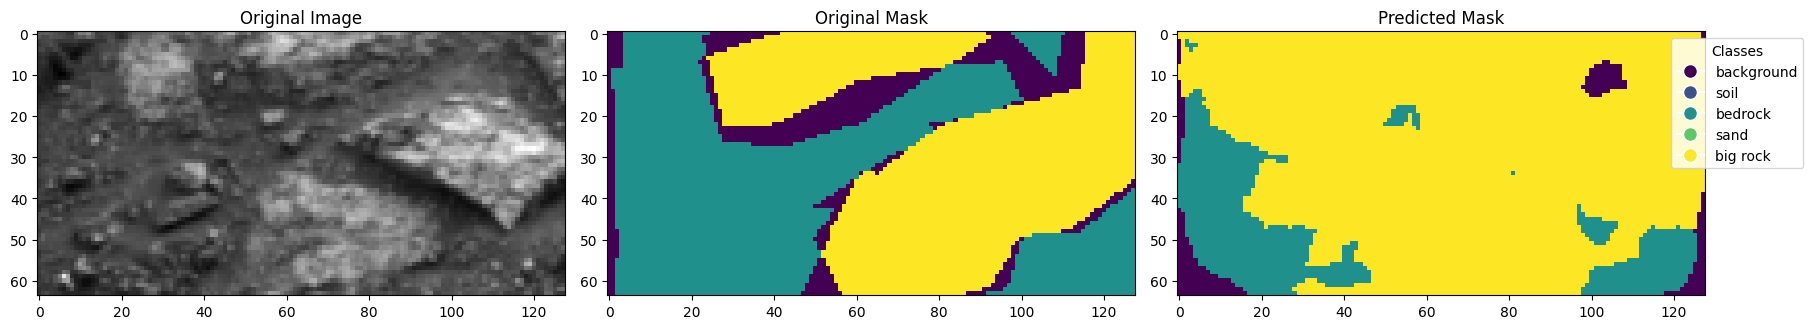

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.6851 - mean_io_u: 0.4416 - val_loss: 0.9985 - val_mean_io_u: 0.3309 - learning_rate: 0.0010
Epoch 21/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.6700 - mean_io_u: 0.4443 - val_loss: 1.9751 - val_mean_io_u: 0.1028 - learning_rate: 0.0010
Epoch 22/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.6611 - mean_io_u: 0.4495 - val_loss: 1.9375 - val_mean_io_u: 0.1727 - learning_rate: 0.0010
Epoch 23/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.6490 - mean_io_u: 0.4512 - val_loss: 1.1288 - val_mean_io_u: 0.2898 - learning_rate: 0.0010
Epoch 24/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.6462 - mean_io_u: 0.4520 - val_loss: 0.8797 - val_mean_io_u: 0.3734 - learning_rate: 0.0010
Epoch 25/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.6340 - mean_io_u: 0.4567 - val_loss: 1.6987 - val_mean_io_u: 0.2069 - learning_rate: 0.0010
Epoch 26/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.6298 - mean_io_u: 0.

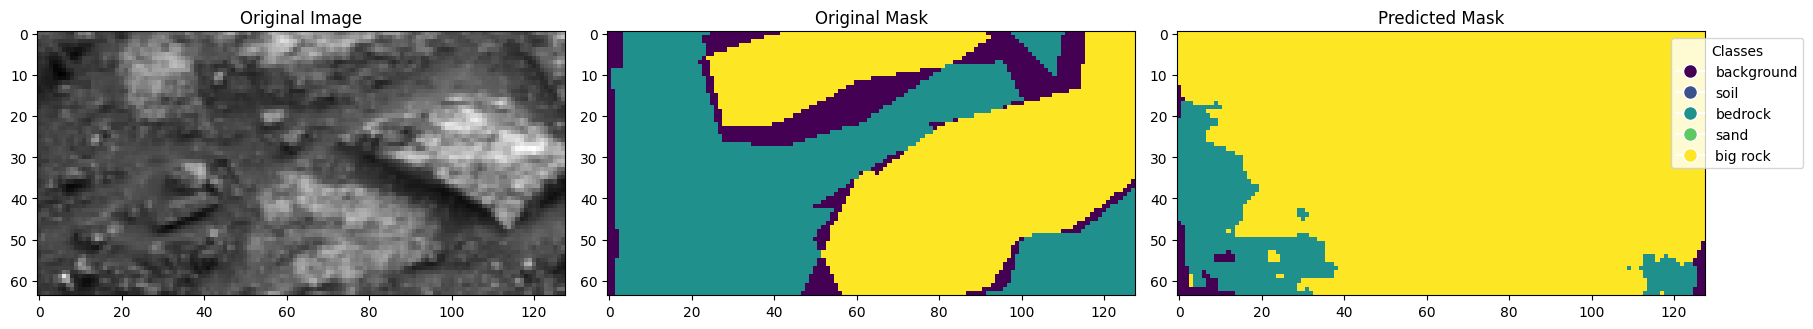

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.6057 - mean_io_u: 0.4644 - val_loss: 1.3658 - val_mean_io_u: 0.3268 - learning_rate: 0.0010
Epoch 31/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.5952 - mean_io_u: 0.4682 - val_loss: 1.1900 - val_mean_io_u: 0.3296 - learning_rate: 0.0010
Epoch 32/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.5859 - mean_io_u: 0.4710 - val_loss: 1.3158 - val_mean_io_u: 0.2749 - learning_rate: 0.0010
Epoch 33/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.5784 - mean_io_u: 0.4729 - val_loss: 0.8330 - val_mean_io_u: 0.4272 - learning_rate: 0.0010
Epoch 34/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.5699 - mean_io_u: 0.4767 - val_loss: 1.0007 - val_mean_io_u: 0.3566 - learning_rate: 0.0010
Epoch 35/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.5620 - mean_io_u: 0.4791 - val_loss: 1.0058 - val_mean_io_u: 0.3786 - learning_rate: 0.0010
Epoch 36/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.5595 - mean_io_u: 0.

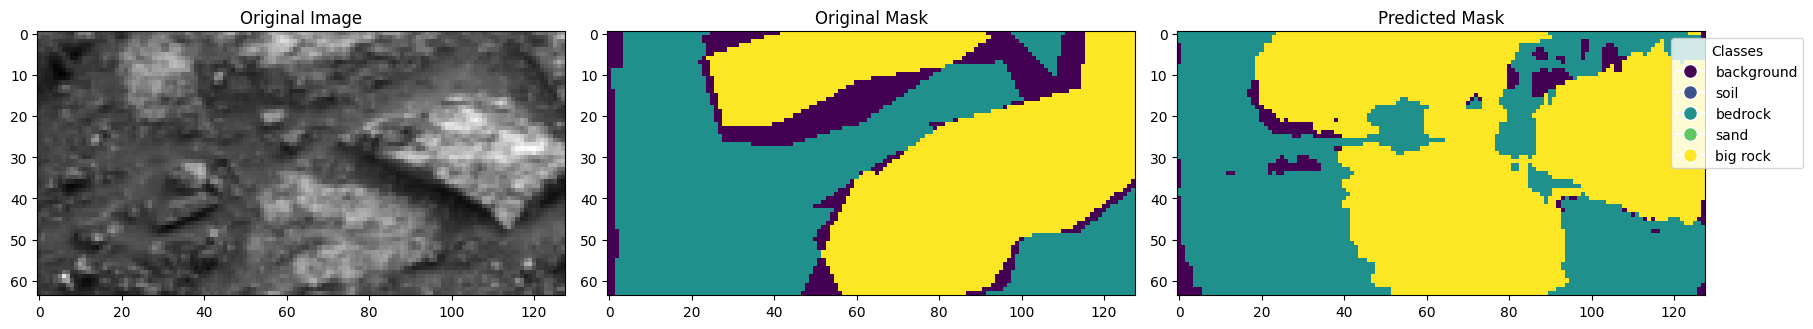

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.5337 - mean_io_u: 0.4874 - val_loss: 1.0116 - val_mean_io_u: 0.3758 - learning_rate: 0.0010
Epoch 41/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.5277 - mean_io_u: 0.4901 - val_loss: 0.8892 - val_mean_io_u: 0.4157 - learning_rate: 0.0010
Epoch 42/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.5247 - mean_io_u: 0.4912 - val_loss: 0.9862 - val_mean_io_u: 0.3946 - learning_rate: 0.0010
Epoch 43/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.5267 - mean_io_u: 0.4907 - val_loss: 0.8406 - val_mean_io_u: 0.4304 - learning_rate: 0.0010
Epoch 44/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.5124 - mean_io_u: 0.5015 - val_loss: 0.8962 - val_mean_io_u: 0.4346 - learning_rate: 0.0010
Epoch 45/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.4968 - mean_io_u: 0.5098 - val_loss: 0.9223 - val_mean_io_u: 0.4228 - learning_rate: 0.0010
Epoch 46/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.4846 - mean_io_u: 0.

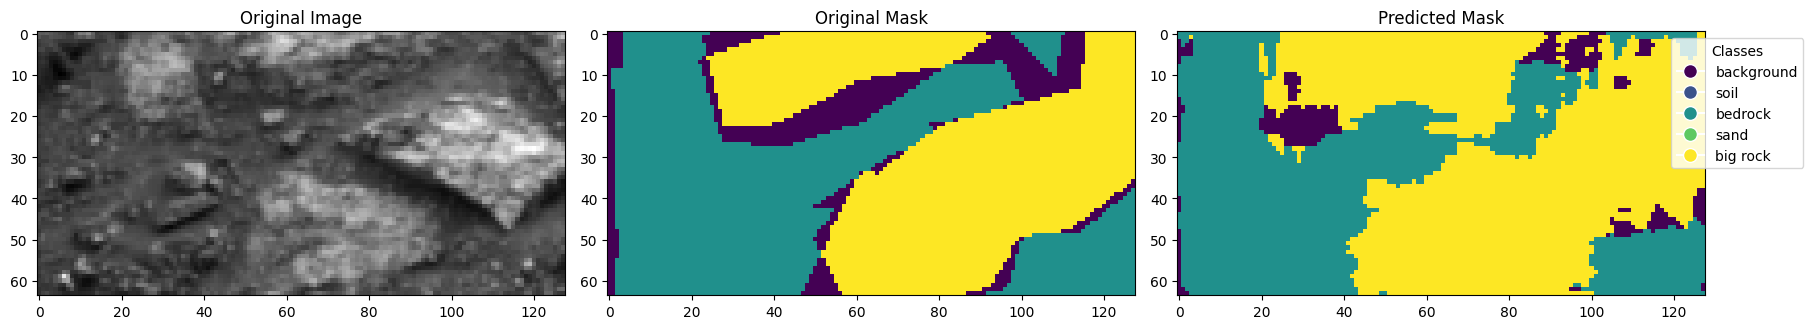

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.4301 - mean_io_u: 0.5215 - val_loss: 0.7782 - val_mean_io_u: 0.4091 - learning_rate: 1.0000e-04
Epoch 51/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.4174 - mean_io_u: 0.5248 - val_loss: 0.7136 - val_mean_io_u: 0.4353 - learning_rate: 1.0000e-04
Epoch 52/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.4098 - mean_io_u: 0.5268 - val_loss: 0.7035 - val_mean_io_u: 0.4388 - learning_rate: 1.0000e-04
Epoch 53/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.4039 - mean_io_u: 0.5283 - val_loss: 0.7164 - val_mean_io_u: 0.4311 - learning_rate: 1.0000e-04
Epoch 54/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.3990 - mean_io_u: 0.5296 - val_loss: 0.7006 - val_mean_io_u: 0.4417 - learning_rate: 1.0000e-04
Epoch 55/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.3946 - mean_io_u: 0.5307 - val_loss: 0.6999 - val_mean_io_u: 0.4435 - learning_rate: 1.0000e-04
Epoch 56/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss

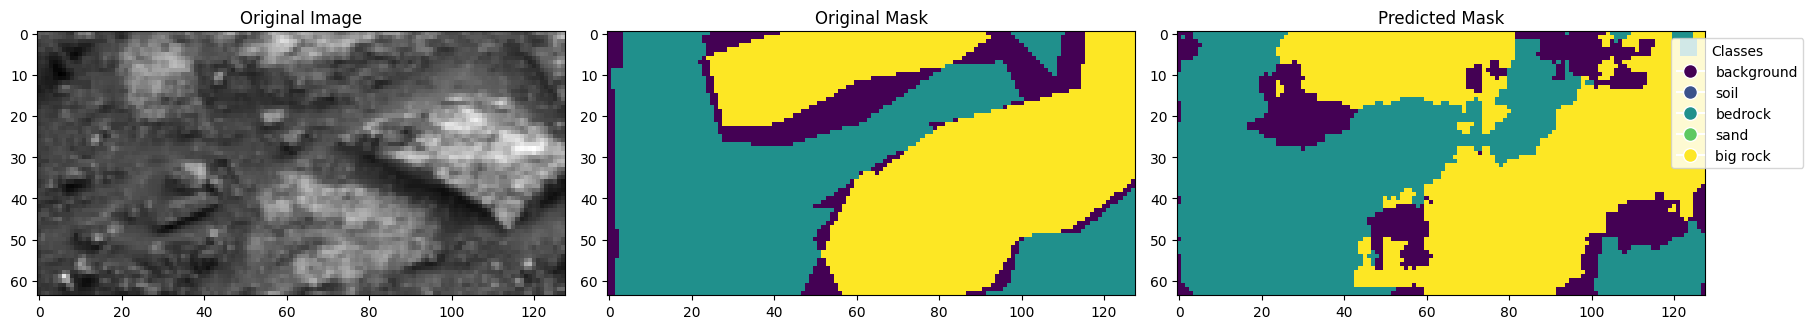

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.3757 - mean_io_u: 0.5363 - val_loss: 0.7169 - val_mean_io_u: 0.4412 - learning_rate: 1.0000e-04
Epoch 61/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.3724 - mean_io_u: 0.5375 - val_loss: 0.7220 - val_mean_io_u: 0.4430 - learning_rate: 1.0000e-04
Epoch 62/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.3690 - mean_io_u: 0.5385 - val_loss: 0.7475 - val_mean_io_u: 0.4331 - learning_rate: 1.0000e-04
Epoch 63/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.3657 - mean_io_u: 0.5397 - val_loss: 0.7660 - val_mean_io_u: 0.4256 - learning_rate: 1.0000e-04
Epoch 64/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.3624 - mean_io_u: 0.5409 - val_loss: 0.7610 - val_mean_io_u: 0.4258 - learning_rate: 1.0000e-04
Epoch 65/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.3592 - mean_io_u: 0.5420 - val_loss: 0.7407 - val_mean_io_u: 0.4366 - learning_rate: 1.0000e-04
Epoch 66/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss

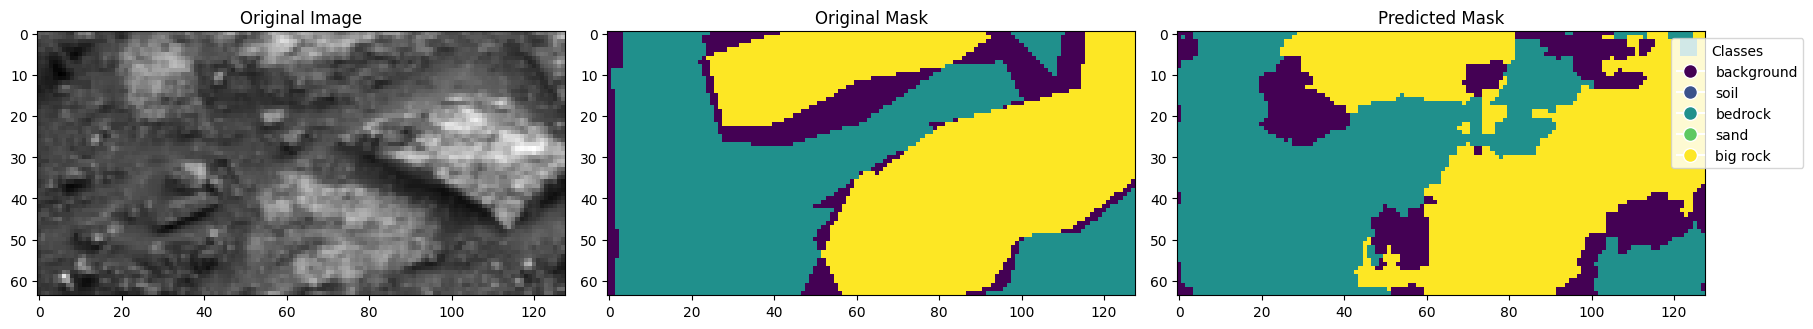

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.3438 - mean_io_u: 0.5491 - val_loss: 0.7592 - val_mean_io_u: 0.4357 - learning_rate: 1.0000e-04
Epoch 71/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.3407 - mean_io_u: 0.5505 - val_loss: 0.7597 - val_mean_io_u: 0.4338 - learning_rate: 1.0000e-04
Epoch 72/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.3397 - mean_io_u: 0.5484 - val_loss: 0.7330 - val_mean_io_u: 0.4526 - learning_rate: 1.0000e-05
Epoch 73/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.3280 - mean_io_u: 0.5535 - val_loss: 0.7344 - val_mean_io_u: 0.4525 - learning_rate: 1.0000e-05
Epoch 74/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.3263 - mean_io_u: 0.5542 - val_loss: 0.7356 - val_mean_io_u: 0.4523 - learning_rate: 1.0000e-05
Epoch 75/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.3253 - mean_io_u: 0.5550 - val_loss: 0.7362 - val_mean_io_u: 0.4520 - learning_rate: 1.0000e-05
Epoch 76/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=300,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

In [ ]:
os.chdir("/gdrive/My Drive/Colab Notebooks")
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
#del model

print(f"Model saved to {model_filename}")

Model saved to model_241214_122412.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from model_241214_122412.keras


In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```